# Read Alignment

We will be using Illumina MiSeq reads from *Shewanella	oneidensis* bacterium to align to both a human and *S.	oneidensis* reference genome to filter contanminated reads, and generate a plot of coverage magnitudes and distribution.  

## Alignments with bowtie2 in terminal:

### Human Genome:    



Wrote in Terminal:

```~/Lab_6S bowtie2 -p 4 --very-fast --no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq -S aligned/sooutput.sam --un sounaligned.fastq```
> **Database used:** /data/hg19/hg19 <br>
**Input reads:** /data/lab6/illumina_reads.fastq <br>
**Output SAM file:** aligned/sooutput.sam <br>
**sounaligned.fastq contains:** reads that did not align to the specified database, meaning these reads should be used for further analysis because they are not contaminated with human DNA. <br>

 **--very-fast** controls the balance between speed and sensitivity (detail). Can also input **--fast**, **--sensitive**, or 
**--very-sensitive as well**.

**--no-unal** tells Bowtie to not report unaligned reads in the output SAM file, and saves space in output.
    
**-x** specifies path to database aligning reads to: in this case the hg19 genome 
 
**-U** specifies path to input reads in FASTQ format. Can also run paired-end reads by using the parameters **-1** and **-2**.
 
**-S** specifies path to the output SAM file 

**--un** tells Bowtie place unaligned reads into a separate FASTQ file in the .




Terminal returns:

    1124714 reads; of these:
    1124714 (100.00%) were unpaired; of these:
        1028379 (91.43%) aligned 0 times
        87274 (7.76%) aligned exactly 1 time
        9061 (0.81%) aligned >1 times
    8.57% overall alignment rate```
    
Therefore our sample was 8.57% contaminated with human genome.  


### *S.	oneidensis* reference	genome

Next we compared filtered reads in the sounaligned.fastq file to the *S. oneidensis* genome to check the quaility of the sequenceing.  

Wrote the following code in terminal to align the S. oneidensis reads to a reference genome of the same bacterium: 

```~/Lab_6S bowtie2 -p 4 --very-fast --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U sounaligned.fastq -S so_aligned/so_output.sam --un so_unaligned.fastq```

> **Input database:** /data/lab6/shewanella_oneidensis_mr-1   
**Input reads:** sounaligned.fastq <br> 
**Output SAM file:** so_aligned/so_output.sam <br> 
**"so_unaligned.fastq" contains:** reads that did not align to the reference genome that are either from errors in PCR, errors in sequencing, or due to potential contamination. <br>  


Terminal returns:

    1028379 reads; of these:
      1028379 (100.00%) were unpaired; of these:
        299560 (29.13%) aligned 0 times
        687571 (66.86%) aligned exactly 1 time
        41248 (4.01%) aligned >1 times
    70.87% overall alignment rate

29.13% of the filterd library did not align to the reference genome. If we used **--verysensitive** instead	of	**--very-fast** this percentage would likely decrease. 

### Analysis of alignments: 

Starting with 1,124,714 reads

**Reads mapped to human genome:** 96,335 out of 1,124,714 when aligned

**Reads mapped to *S. oneidensis* genome:** 728,819 out of 1,028,379 when aligned

## Coverage Caluclation with samtools:

**SAM file containing aligned reads:** Lab_6/so_aligned/so_output.sam

**Convert:** We first converted our input SAM file, 'so_output.sam', to an output BAM file, 'so_output.bam', by using the samtools ```view``` command:  

```samtools view –b so_output.sam > so_output.bam```

> This prints specified files in specified formats (BAM, CRAM, BED), or if unspecified prints all alignments in the specified input file in SAM format. ```-b``` specifies the output will be in BAM format and is followed by input alignments path, ```>``` then the output file path.  

<br>

**Sort:** Next we sorted our input BAM file, 'so_output.bam', by the alignments leftmost chromosomal coordinates and saving as output file 'so_output.sorted.bam' by using the ```sort``` command:

```samtools sort so_output.bam > so_output.sorted.bam```

> This was done in an inflexible way by just specifying the input ```>``` output file names, and options like ```-n``` could be used to instead sort by name.  

<br>

**Index:** The sorted input 'so_output.sorted.bam' BAM file then had to be run through the command ```index```:

```samtools index so_output.sorted.bam```

> This command takes a specified sorted BAM or CRAM file and indexes it for fast random access. Since we did not specify a specific output file the input was indexed and saved in a BAI file called 'so_output.sorted.bam.bai' , which acts as an external table of contents for the BAM file and allows algorithms random access.

<br>

**Calculate depth of coverage:** Use ```depth``` command to	take the sorted BAM file with it's index BAI companion file to calculate the depth	of	coverage for every position	in	the	reference genome:

```samtools depth –a so_output.sorted.bam > so_pileup.tab```

> The ```–a``` parameter tells samtools to output zeroes for positions with no coverage 

**What is a TAB file?** 

Tab-delimited files are text files that are organized into rows and columns that uses two rwo punctuation riles to encode data: 
* Rows deliminated with newline character (```\n```). Rows in the file contain data for the corresponding position of nt, starting with 1 

* Within a row, columns are delimited by a single character (often ```\t```). Columns are as follows: reference genome name, position index, number of reads alined there. 


## Results visualized with matplotlib

Now to assess how well the sequencing went we need to visualize the coverage in a way that is informative.

### Scatterplot of reads over positons in *S. oneidensis* genome: 

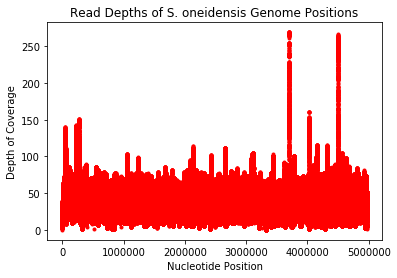

In [96]:
import matplotlib.pyplot as plt
import csv
%matplotlib inline
x_pos = []
y_dep = []

with open('so_pileup.tab','r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    for row in plots:
        x_pos.append(int(row[1]))
        y_dep.append(int(row[2]))        

#Test that my function worked correctly by comparing the first 20 positions and depths to those in the opened TAB file
#print(x_pos[:20]) = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#print(y_dep[:20]) = [0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3]

#Load data into scatterplot:
plt.plot(x_pos, y_dep,'r.')

#Label scatterplot: 
plt.title("Read Depths of S. oneidensis Genome Positions")  
plt.xlabel("Nucleotide Position") 
plt.ylabel("Depth of Coverage")

#show plot:
plt.show() 

This scatterplot shows us that the genome seems to be covered fully, but there were a few sections that got an abnormally high amount of reads like just below 4000 kb and 5000 kb.

### Histogram of coverage depth distribution: 

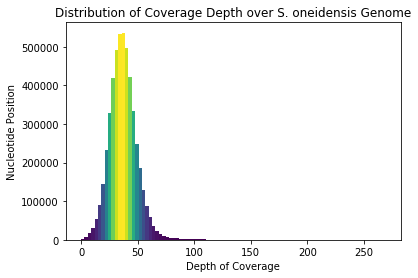

In [95]:
import matplotlib.pyplot as plt

#Load data into histogram: 
N, bins, patches = plt.hist(y_dep, bins= 90)

#Made graph beautiful: 
import matplotlib.colors     

fracs = N / N.max()
#Colors depend on the height or number of objects in bin (N)

norm = matplotlib.colors.Normalize(fracs.min(), fracs.max())
#Uses matplotlib.colors to grab colors depending on fractions of the height

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

#Label Histogram: 
plt.title("Distribution of Coverage Depth over S. oneidensis Genome")  
plt.xlabel("Depth of Coverage") 
plt.ylabel("Nucleotide Position")

#show plot:
plt.show()

In [86]:
import statistics

print(max(y_dep))
#max = 269

print(min(y_dep))
#min = 0

print(statistics.mean(y_dep))
#mean= 36.956

269
0
36.955644792125895


**What	is	the	min, max, and mean coverage	across all positions?**

The maximum is 269 reads, the minimum is 0, and the mean coverage is 36.956. This can be assertained by looking at the histogram  

You can conclude that this was **not** a very successful seqeuncing attempt because: 
* the read depths are skewed to the left, meaning there was more weaker coverage than stronger coverage
* the genome was more or less evenly covered except for two positions that were just below 4,000,000 and just below 5,000,000